In [252]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score
from sklearn.metrics import accuracy_score

# READ FROM DATABASE

In [253]:
import psycopg2
import pickle
import copy

In [254]:
# jdbc:postgresql://pg-graduate-delt.postgres.database.azure.com:5432/{your_database}?user=snartimaal&password={your_password}&sslmode=require
with psycopg2.connect(
    database='pgsql-graduate-gruppe3',
    user='snartimaal',
    password='#st44p44nu',
    host='pg-graduate-delt.postgres.database.azure.com'
) as conn:
    cur = conn.cursor()

### Mattilsynet 

In [274]:
try:
    cur = conn.cursor()
    df_sql_mat = pd.read_sql_query("SELECT cs.overordnetenhet, m.orgnummer, m.postnr, m.total_karakter, m.dato, m.tilsynsbesoektype, cs.antallansatte, cs.naeringskode1_kode \
                                  FROM mattilsynet m \
                                  JOIN orgnumber_junction oj ON m.orgnummer = oj.orgnumber \
                                  JOIN company_subunit cs ON oj.orgnumber = cs.organisasjonsnummer;", 
                                  conn)
except:
    conn.rollback()
    cur.close()

C:\Users\CL\AppData\Local\Temp\ipykernel_9168\2236806454.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_sql_mat = pd.read_sql_query("SELECT cs.overordnetenhet, m.orgnummer, m.postnr, m.total_karakter, m.dato, m.tilsynsbesoektype, cs.antallansatte, cs.naeringskode1_kode \


In [275]:
df_sql_mat

,overordnetenhet,orgnummer,postnr,total_karakter,dato,tilsynsbesoektype,antallansatte,naeringskode1_kode
0,915708951,915937144,368,2,21112022,1,69.0,56.101
1,915647774,974999439,366,0,23012020,0,17.0,47.241
2,915865488,915893848,369,0,14092017,1,25.0,56.101
3,919146133,919228660,178,0,21082018,1,7.0,56.101
4,931531018,912240770,1081,0,26112018,1,80.0,55.101
...,...,...,...,...,...,...,...,...
5836,925417165,915465870,194,0,19012023,1,34.0,56.101
5837,994668749,996480550,190,1,01092022,0,4.0,56.102
5838,913473302,913536835,194,0,09092022,0,4.0,56.101
5839,929609220,929774671,179,1,12122022,0,21.0,56.101


# Ledere
Styremedlemer, Styreleder, Nestleder, Vara etc.

In [257]:
list_of_df = [  "df_styremedlemjunction_table",
                "df_varamedlemjunction_table",
                "df_styrets_lederjunction_table",
                "df_nestlederjunction_table",
                "df_kontaktpersonjunction_table",
                "df_innehaverjunction_table"]
daglig_leder = "df_daglig_lederjunction_table"
people = "df_people_gender"

In [165]:
def get_leader_info(name):
    path_ = "../Data/Extracted/"
    suffix = ".obj"

    with open(path_+name+suffix, 'rb') as f:
        df = pickle.load(f)
    return df

In [166]:
df_people = get_leader_info(people)
daglig_leder = get_leader_info(daglig_leder)

In [167]:
leaders = []

for item in list_of_df:
    leaders.append(get_leader_info(item))

In [168]:
# Gets all leaders for each org number.

list_of_org_num = df_sql_mat['overordnetenhet'].tolist()
unique_leader = {}
for org_num in list_of_org_num:
    unique_leader[org_num] = []

count = 0
for org_num in list_of_org_num:
    count += 1

    for leader_role in leaders:

        for index, row in leader_role.iterrows():

            if int(row['organisasjonsnummer']) == int(org_num):
                unique_leader[org_num].append(row['person_id'])

In [169]:
# Reduces the leaders for each org number to only unique.
only_unique_leader = {}
for key, value in unique_leader.items():
    only_unique_leader[key] = list(set(value))

In [170]:
# Count of leaders and the gender rate. 0 beeing all female and 1 beeing all male.
counted_leaders = {}
for key, value in only_unique_leader.items():
    sex = 0
    for leader in value:
        sex = sex + int(df_people.loc[df_people['person_id'] == leader, 'sex'])
        
    if len(value) == 0:
        counted_leaders[key] = [len(value), np.nan]
    else:
        counted_leaders[key] = [len(value), sex/len(value)]

### Daglig leder

In [171]:
# Gets all aglig leaders for each org number.

list_of_org_num = df_sql_mat['overordnetenhet'].tolist()
unique_leader = {}
for org_num in list_of_org_num:
    unique_leader[org_num] = []

for org_num in list_of_org_num:

    for index, row in daglig_leder.iterrows():

        if int(row['organisasjonsnummer']) == int(org_num):
            unique_leader[org_num].append(row['person_id'])

In [172]:
# Reduces the leaders for each org number to only unique.
only_unique_leader = {}
for key, value in unique_leader.items():
    only_unique_leader[key] = list(set(value))

In [173]:
# Count of leaders and the gender rate. 0 beeing all female and 1 beeing all male.
counted_daglig_leaders = {}
for key, value in only_unique_leader.items():
    sex = 0
    for leader in value:
        sex = sex + int(df_people.loc[df_people['person_id'] == leader, 'sex'])
        
    if len(value) == 0:
        counted_daglig_leaders[key] = [len(value), np.nan]
    else:
        counted_daglig_leaders[key] = [len(value), sex/len(value)]

In [258]:
print(len(counted_daglig_leaders))
print(len(counted_leaders))

992
992


### Styremedlemmer

In [276]:
try:
    cur = conn.cursor()
    df_sql_styre = pd.read_sql_query("SELECT m.orgnummer, p.person_id, oj.org_name \
                                  FROM mattilsynet m \
                                  JOIN orgnumber_junction oj ON m.orgnummer = oj.orgnumber \
                                  JOIN styremedlem_junction sj ON oj.orgnumber = sj.organisasjonsnummer \
                                  JOIN people p ON sj.person_id = p.person_id ;", 
                                  conn)
except:
    conn.rollback()
    cur.close()


C:\Users\CL\AppData\Local\Temp\ipykernel_9168\2516288090.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_sql_styre = pd.read_sql_query("SELECT m.orgnummer, p.person_id, oj.org_name \


### Google Review

In [277]:
try:
    cur = conn.cursor()
    df_sql_reviews = pd.read_sql("SELECT gr.organisasjonsnummer AS orgnummer, gr.individual_rating \
                                 FROM google_review gr;", 
                                 conn)
except:
    conn.rollback()
    cur.close()


C:\Users\CL\AppData\Local\Temp\ipykernel_9168\2155275846.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_sql_reviews = pd.read_sql("SELECT gr.organisasjonsnummer AS orgnummer, gr.individual_rating \


In [278]:
avg_df = df_sql_reviews.groupby('orgnummer').mean()
min_max_df = (df_sql_reviews.groupby('orgnummer').max()) - (df_sql_reviews.groupby('orgnummer').min())
min_max_df['dif_rating'] = min_max_df.pop('individual_rating')
avg_df['avg_rating'] = avg_df.pop('individual_rating')

In [279]:
df_sql_mat

,overordnetenhet,orgnummer,postnr,total_karakter,dato,tilsynsbesoektype,antallansatte,naeringskode1_kode
0,915708951,915937144,368,2,21112022,1,69.0,56.101
1,915647774,974999439,366,0,23012020,0,17.0,47.241
2,915865488,915893848,369,0,14092017,1,25.0,56.101
3,919146133,919228660,178,0,21082018,1,7.0,56.101
4,931531018,912240770,1081,0,26112018,1,80.0,55.101
...,...,...,...,...,...,...,...,...
5836,925417165,915465870,194,0,19012023,1,34.0,56.101
5837,994668749,996480550,190,1,01092022,0,4.0,56.102
5838,913473302,913536835,194,0,09092022,0,4.0,56.101
5839,929609220,929774671,179,1,12122022,0,21.0,56.101


In [467]:
df_test = pd.merge(df_sql_mat, avg_df, how='left', on='orgnummer')
df_test = pd.merge(df_test, min_max_df, how='left', on='orgnummer')

In [468]:
df_test

,overordnetenhet,orgnummer,postnr,total_karakter,dato,tilsynsbesoektype,antallansatte,naeringskode1_kode,avg_rating,dif_rating
0,915708951,915937144,368,2,21112022,1,69.0,56.101,4.4,2.0
1,915647774,974999439,366,0,23012020,0,17.0,47.241,4.0,2.0
2,915865488,915893848,369,0,14092017,1,25.0,56.101,4.6,1.0
3,919146133,919228660,178,0,21082018,1,7.0,56.101,4.8,1.0
4,931531018,912240770,1081,0,26112018,1,80.0,55.101,3.2,3.0
...,...,...,...,...,...,...,...,...,...,...
5836,925417165,915465870,194,0,19012023,1,34.0,56.101,NaN,NaN
5837,994668749,996480550,190,1,01092022,0,4.0,56.102,2.4,4.0
5838,913473302,913536835,194,0,09092022,0,4.0,56.101,5.0,0.0
5839,929609220,929774671,179,1,12122022,0,21.0,56.101,2.6,4.0


In [469]:
df_test.isnull().sum()

overordnetenhet         0
orgnummer               0
postnr                  0
total_karakter          0
dato                    0
tilsynsbesoektype       0
antallansatte           0
naeringskode1_kode      0
avg_rating            658
dif_rating            658
dtype: int64

In [470]:
mean_avg = df_test['avg_rating'].mean()
mean_dif = df_test['dif_rating'].mean()
dt_test = df_test['avg_rating'].fillna(value=mean_avg, inplace=True)
dt_test = df_test['dif_rating'].fillna(value=mean_dif, inplace=True)

#### Adding cordinate location.

In [471]:
try:
    cur = conn.cursor()
    df_cordinates = pd.read_sql_query(""" 
            SELECT m.orgnummer, a.latitude, a.longitude
            FROM address a
            JOIN mattilsynet m on a.name = m.adresse;
            """
                            ,conn)
except:
    conn.rollback()
    cur.close()

InterfaceError: connection already closed

In [472]:
df_cordinates.columns

Index(['orgnummer', 'latitude', 'longitude'], dtype='object')

In [473]:
df_test.columns

Index(['overordnetenhet', 'orgnummer', 'postnr', 'total_karakter', 'dato',
       'tilsynsbesoektype', 'antallansatte', 'naeringskode1_kode',
       'avg_rating', 'dif_rating'],
      dtype='object')

In [474]:
df_test

,overordnetenhet,orgnummer,postnr,total_karakter,dato,tilsynsbesoektype,antallansatte,naeringskode1_kode,avg_rating,dif_rating
0,915708951,915937144,368,2,21112022,1,69.0,56.101,4.400000,2.000000
1,915647774,974999439,366,0,23012020,0,17.0,47.241,4.000000,2.000000
2,915865488,915893848,369,0,14092017,1,25.0,56.101,4.600000,1.000000
3,919146133,919228660,178,0,21082018,1,7.0,56.101,4.800000,1.000000
4,931531018,912240770,1081,0,26112018,1,80.0,55.101,3.200000,3.000000
...,...,...,...,...,...,...,...,...,...,...
5836,925417165,915465870,194,0,19012023,1,34.0,56.101,4.096913,2.154158
5837,994668749,996480550,190,1,01092022,0,4.0,56.102,2.400000,4.000000
5838,913473302,913536835,194,0,09092022,0,4.0,56.101,5.000000,0.000000
5839,929609220,929774671,179,1,12122022,0,21.0,56.101,2.600000,4.000000


In [475]:
df_cordinates = df_cordinates.drop_duplicates(subset=['orgnummer'])

In [476]:
df_cordinates

,orgnummer,latitude,longitude
0,915893848,59.930309,10.715419
2,919228660,59.922427,10.751924
17,912240770,59.930122,10.868260
18,917686149,59.936102,10.765475
21,873357312,59.977237,10.655501
...,...,...,...
4009,921905750,59.927632,10.796924
4131,925779318,59.901814,10.741166
4198,925872407,59.915589,10.755933
4207,927372371,59.914255,10.748027


In [477]:
# Merging the df's
df_test = df_test.merge(df_cordinates, how='left', on='orgnummer')

In [478]:
df_test

,overordnetenhet,orgnummer,postnr,total_karakter,dato,tilsynsbesoektype,antallansatte,naeringskode1_kode,avg_rating,dif_rating,latitude,longitude
0,915708951,915937144,368,2,21112022,1,69.0,56.101,4.400000,2.000000,NaN,NaN
1,915647774,974999439,366,0,23012020,0,17.0,47.241,4.000000,2.000000,NaN,NaN
2,915865488,915893848,369,0,14092017,1,25.0,56.101,4.600000,1.000000,59.930309,10.715419
3,919146133,919228660,178,0,21082018,1,7.0,56.101,4.800000,1.000000,59.922427,10.751924
4,931531018,912240770,1081,0,26112018,1,80.0,55.101,3.200000,3.000000,59.930122,10.868260
...,...,...,...,...,...,...,...,...,...,...,...,...
5836,925417165,915465870,194,0,19012023,1,34.0,56.101,4.096913,2.154158,59.902836,10.753338
5837,994668749,996480550,190,1,01092022,0,4.0,56.102,2.400000,4.000000,59.912518,10.765009
5838,913473302,913536835,194,0,09092022,0,4.0,56.101,5.000000,0.000000,NaN,NaN
5839,929609220,929774671,179,1,12122022,0,21.0,56.101,2.600000,4.000000,59.914400,10.747041


In [479]:
df_test.columns

Index(['overordnetenhet', 'orgnummer', 'postnr', 'total_karakter', 'dato',
       'tilsynsbesoektype', 'antallansatte', 'naeringskode1_kode',
       'avg_rating', 'dif_rating', 'latitude', 'longitude'],
      dtype='object')

#### Adding in the leader and direct leader data.

In [480]:
df_test['direct_leader'] = np.nan
df_test['direct_leader_sex'] = np.nan
df_test['leaders'] = np.nan
df_test['leaders_sex'] = np.nan

In [481]:
def add_data_to_df(o_org, gender = False, direct = True):
    index = 0
    if gender == False:
        index = 0
    else:
        index = 1
    
    if direct == True:
        data = counted_daglig_leaders
    else:
        data = counted_leaders

    return data[o_org][index]

In [482]:
df_test['direct_leader'] = df_test['overordnetenhet'].map(lambda x: add_data_to_df(x, gender = False, direct = True))
df_test['direct_leader_sex'] = df_test['overordnetenhet'].map(lambda x: add_data_to_df(x, gender = True, direct = True))
df_test['leaders'] = df_test['overordnetenhet'].map(lambda x: add_data_to_df(x, gender = False, direct = False))
df_test['leaders_sex'] = df_test['overordnetenhet'].map(lambda x: add_data_to_df(x, gender = True, direct = False))

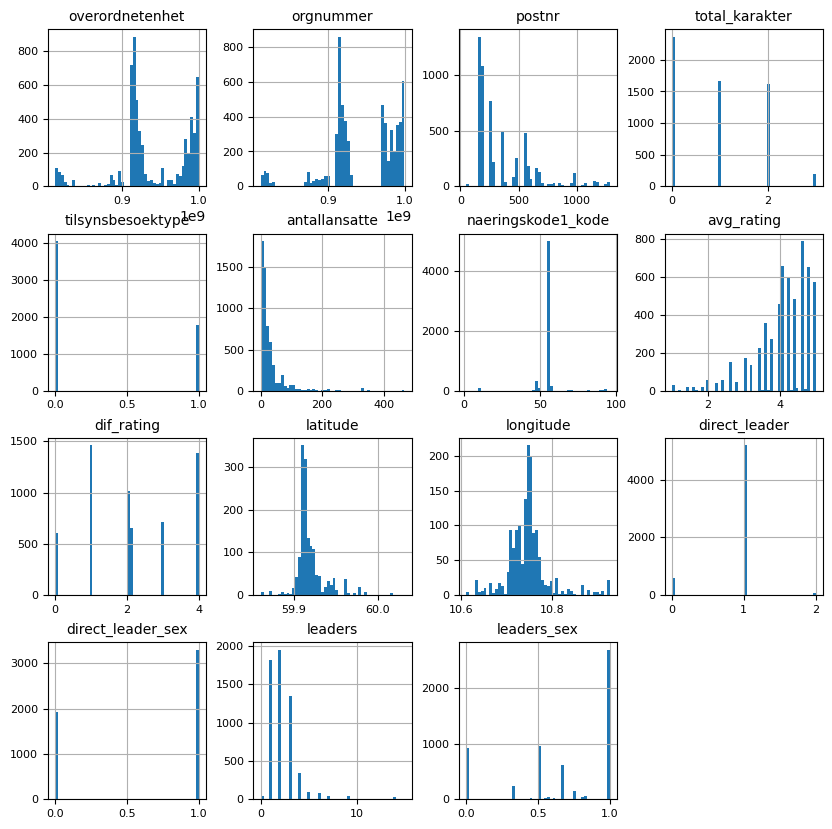

In [483]:
fig = df_test.hist(figsize=[10,10], bins=50, xlabelsize=8, ylabelsize=8)
[x.title.set_size(10) for x in fig.ravel()];
plt.show()

# DATA PREP

In [484]:
# Endre dato til kun år ? De 4 siste sifrene 
dato = df_test['dato']
year_list = []

for i in dato.values:
    year_list.append(int(i[-4:]))

df_test['year'] = year_list

In [485]:
del df_test['overordnetenhet']
df_test

,orgnummer,postnr,total_karakter,dato,tilsynsbesoektype,antallansatte,naeringskode1_kode,avg_rating,dif_rating,latitude,longitude,direct_leader,direct_leader_sex,leaders,leaders_sex,year
0,915937144,368,2,21112022,1,69.0,56.101,4.400000,2.000000,NaN,NaN,1,1.0,3,1.000000,2022
1,974999439,366,0,23012020,0,17.0,47.241,4.000000,2.000000,NaN,NaN,1,1.0,3,1.000000,2020
2,915893848,369,0,14092017,1,25.0,56.101,4.600000,1.000000,59.930309,10.715419,1,0.0,5,0.600000,2017
3,919228660,178,0,21082018,1,7.0,56.101,4.800000,1.000000,59.922427,10.751924,0,NaN,2,0.500000,2018
4,912240770,1081,0,26112018,1,80.0,55.101,3.200000,3.000000,59.930122,10.868260,1,1.0,9,0.555556,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5836,915465870,194,0,19012023,1,34.0,56.101,4.096913,2.154158,59.902836,10.753338,1,1.0,1,1.000000,2023
5837,996480550,190,1,01092022,0,4.0,56.102,2.400000,4.000000,59.912518,10.765009,1,0.0,1,1.000000,2022
5838,913536835,194,0,09092022,0,4.0,56.101,5.000000,0.000000,NaN,NaN,1,1.0,2,0.500000,2022
5839,929774671,179,1,12122022,0,21.0,56.101,2.600000,4.000000,59.914400,10.747041,1,1.0,2,1.000000,2022


In [486]:
# Adding monthly data
month = df_test['dato']
month_list = []

for i in dato.values:
    month_list.append(int(i[2:-4:]))

df_test['month'] = month_list

In [410]:
df_unscaled = copy.deepcopy(df_test)

In [428]:
df_test = df_unscaled

In [487]:
df_test.columns

Index(['orgnummer', 'postnr', 'total_karakter', 'dato', 'tilsynsbesoektype',
       'antallansatte', 'naeringskode1_kode', 'avg_rating', 'dif_rating',
       'latitude', 'longitude', 'direct_leader', 'direct_leader_sex',
       'leaders', 'leaders_sex', 'year', 'month'],
      dtype='object')

In [465]:
# Data scaling should not be importaint with xgboost

# ss_features = [ 'postnr', 'orgnummer', 'tilsynsbesoektype', 
#                 'naeringskode1_kode', 'antallansatte', 'avg_rating', 
#                 'dif_rating', 'latitude', 'longitude', 'direct_leader', 
#                 'direct_leader_sex', 'leaders', 'leaders_sex', 'year', 'month']
# ss_scaler = StandardScaler()
# ss_scaler.fit(df_test[ss_features])
# transformed_ss = ss_scaler.transform(df_test[ss_features])
# df_test[ss_features] = transformed_ss

# TRAIN TEST SPLIT

In [488]:
df_test.columns

Index(['orgnummer', 'postnr', 'total_karakter', 'dato', 'tilsynsbesoektype',
       'antallansatte', 'naeringskode1_kode', 'avg_rating', 'dif_rating',
       'latitude', 'longitude', 'direct_leader', 'direct_leader_sex',
       'leaders', 'leaders_sex', 'year', 'month'],
      dtype='object')

In [489]:
feature_list = ['orgnummer', 'postnr',
       'antallansatte', 'naeringskode1_kode', 'avg_rating', 'dif_rating',
       'latitude', 'longitude', 'direct_leader', 'direct_leader_sex',
       'leaders', 'leaders_sex', 'year', 'month']

In [ ]:
# feature_list = ['orgnummer', 'postnr', 'tilsynsbesoektype',
#        'antallansatte', 'naeringskode1_kode', 'avg_rating', 'dif_rating',
#        'latitude', 'longitude', 'direct_leader', 'direct_leader_sex',
#        'leaders', 'leaders_sex', 'year', 'month']

In [490]:
features_test = df_test[feature_list]
X = np.c_[features_test]
y = np.c_[df_test['total_karakter']]

In [491]:
print(f'X len : {len(X)}')
print(f'y len : {len(y)}')

X len : 5841
y len : 5841


In [492]:
print(X.data.shape,
y.data.shape)

(5841, 14) (5841, 1)


In [493]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [494]:
print(f'X_train len : {len(X_train)}')
print(f'X_test len : {len(X_test)}')
print(f'y_train len : {len(y_train)}')
print(f'y_test len : {len(y_test)}')

X_train len : 4672
X_test len : 1169
y_train len : 4672
y_test len : 1169


In [495]:
print(X_train.shape, y_train.shape)

(4672, 14) (4672, 1)


# Naiv score

In [496]:
pred_naiv = np.mean(y_train)
y_pred_naiv = np.full(y_test.shape, pred_naiv)
print(f'y_pred_naiv : {len(y_pred_naiv)}') # 1169

mse_naiv = mean_squared_error(y_test, y_pred_naiv)
print(f'Naiv MSE : {np.sqrt(mse_naiv)}') # 0.9147

mae_naiv = mean_absolute_error(y_test, y_pred_naiv)
print(f'Naiv MAE : {mae_naiv}') # 0.7819

y_pred_naiv : 1169
Naiv MSE : 0.8977701014613035
Naiv MAE : 0.7547403968970084


# XGBoost Model

In [497]:
regressor = xgb.XGBRegressor(
    early_stopping_rounds = 20,
    max_depth = 5
)

regressor.fit(X_train, y_train, eval_set = [(X_test, y_test)])
importance_check = pd.DataFrame(regressor.feature_importances_.reshape(1,-1), columns = [feature_list])


[0]	validation_0-rmse:0.94820
[1]	validation_0-rmse:0.92019
[2]	validation_0-rmse:0.90589
[3]	validation_0-rmse:0.89932
[4]	validation_0-rmse:0.89820
[5]	validation_0-rmse:0.90112
[6]	validation_0-rmse:0.90076
[7]	validation_0-rmse:0.90238
[8]	validation_0-rmse:0.90560
[9]	validation_0-rmse:0.90869
[10]	validation_0-rmse:0.91202
[11]	validation_0-rmse:0.91346
[12]	validation_0-rmse:0.91464
[13]	validation_0-rmse:0.91591
[14]	validation_0-rmse:0.91845
[15]	validation_0-rmse:0.92184
[16]	validation_0-rmse:0.92379
[17]	validation_0-rmse:0.92579
[18]	validation_0-rmse:0.92929
[19]	validation_0-rmse:0.93113
[20]	validation_0-rmse:0.93401
[21]	validation_0-rmse:0.93541
[22]	validation_0-rmse:0.93727
[23]	validation_0-rmse:0.93820
[24]	validation_0-rmse:0.94191


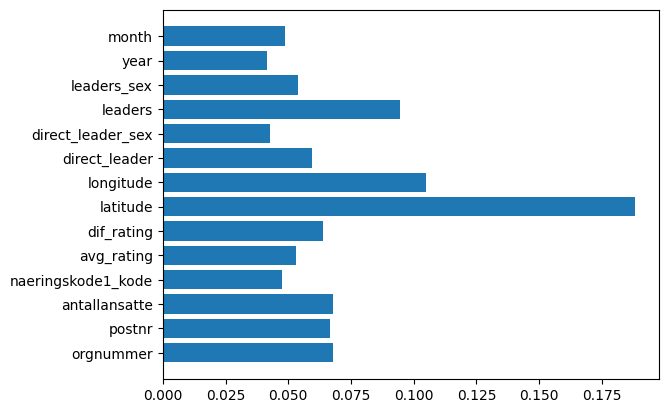

In [498]:
plt.barh(feature_list, regressor.feature_importances_)
plt.show()

# Scoring xg

In [499]:
# Train xg
r2_train_xg = regressor.score(X_train, y_train)
print(f'Train R2 XG : {r2_train_xg}') # 6f 0.3071 / m.år 0.4545

y_pred_train_xg = regressor.predict(X_train)
mse_train_xg = mean_squared_error(y_train, y_pred_train_xg)
print(f'Train MSE XG : {np.sqrt(mse_train_xg)}') # 6f 0.7480 / m.år 0.6641

mae_train_xg = mean_absolute_error(y_train, y_pred_train_xg)
print(f'Train MAE XG : {mae_train_xg}') # 6f 0.5854 / m.år 0.5156

# Test xg
r2_test_xg = regressor.score(X_test, y_test)
print(f'Test R2 XG : {r2_test_xg}') # 6f 0.1754 / m.år 0.2766

y_pred_test_xg = regressor.predict(X_test)
mse_test_xg = mean_squared_error(y_test, y_pred_test_xg)
print(f'Test MSE XG : {np.sqrt(mse_test_xg)}') # 6f 0.8305 / m.år 0.7755

mae_test_xg = mean_absolute_error(y_test, y_pred_test_xg)
print(f'Train MAE XG : {mae_test_xg}') # 6f 0.6631 / m.år 0.6029

Train R2 XG : 0.05293141864662787
Train MSE XG : 0.8787659844094756
Train MAE XG : 0.7506172825033738
Test R2 XG : -0.0011616816472919123
Test MSE XG : 0.898204925539912
Train MAE XG : 0.763163348094228


# Linear Regression Model

In [425]:
lin_reg_model = LinearRegression()
lin_reg_model.fit(X_test, y_test)

## TRAIN

r2_train = lin_reg_model.score(X_train, y_train)
y_train_pred_linreg = lin_reg_model.predict(X_train)
mae_train = mean_absolute_error(y_train, y_train_pred_linreg)
mse_train = mean_squared_error(y_train, y_train_pred_linreg)
print(f'Train R2 : {r2_train}') # 0.1616 / 6f 0.17036 / m.år 0.1595
print(f'Train MAE : {mae_train}') # 0.6758 / 6f 0.6559 / m.år 0.6557
print(f'Train MSE : {np.sqrt(mse_train)}') # 0.8256 / 6f 0.8185 / m.år 0.8244

## TEST

r2_test = lin_reg_model.score(X_test, y_test)
y_test_pred_linreg = lin_reg_model.predict(X_test)
mae_test = mean_absolute_error(y_test, y_test_pred_linreg)
mse_test = mean_squared_error(y_test, y_test_pred_linreg)
print(f'Test R2 : {r2_test}') # 0.1802 / 6f 0.1664 / m.år 0.2152
print(f'Test MAE : {mae_test}') # 0.6662 / 6f 0.6802 / m.år 0.6399
print(f'Test MSE : {np.sqrt(mse_test)}') # 0.8164 / 6f 0.8351 / m.år 0.8077

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

# Logistic Regression Model

In [426]:
# y_train = y_train.reshape(-1)
log_reg_model = LogisticRegression(max_iter = 1000)
log_reg_model.fit(X_train, y_train)

y_pred_cm = log_reg_model.predict(X_train)
#y_train_pred_prod = log_reg_model.predict_proba(X_train)
#y_train_pred_prod_1 = y_train_pred_prod[:,1]
#y_train_pred = y_train_pred_prod_1 > 0.1

train_acc = accuracy_score(y_train, y_pred_cm)
print(f'Train accuracy : {train_acc}')

cm_train = confusion_matrix(y_train, y_pred_cm)

tn_train = cm_train[0,0]
fp_train = cm_train[1,1]
fn_train = cm_train[2,2]
tp_train = cm_train[3,3]

precision_train = tp_train/(tp_train+fp_train)
recall_train = tp_train/(tp_train+fn_train)
print(f'Train Precision : {precision_train}')
print(f'Train Recall : {recall_train}')

ConfusionMatrixDisplay(cm_train).plot()
plt.show()

ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

# KNeighbors Regressor Model

In [427]:
model_knn = KNeighborsRegressor(n_neighbors=15)
model_knn.fit(X_train, y_train)

# KNN score
# Train
R2_train_knn = model_knn.score(X_train, y_train)
y_pred_train_knn = model_knn.predict(X_train)
mae_train_knn = mean_absolute_error(y_train, y_pred_train_knn)
mse_train_knn = mean_squared_error(y_train, y_pred_train_knn)
print(f'Knn Train Score:')
print(f'R2_train : {R2_train_knn}') # 0.3681
print(f'MAE train : {mae_train_knn}') # 0.5506
print(f'MSE train : {np.sqrt(mse_train_knn)}') # 0.7171

# Test
R2_test_knn = model_knn.score(X_test, y_test)
y_test_pred_knn = model_knn.predict(X_test)
mae_test_knn = mean_absolute_error(y_test, y_test_pred_knn)
mse_test_knn = mean_squared_error(y_test, y_test_pred_knn)
print(f'Knn Test Score:')
print(f'R2_test : {R2_test_knn}') # 0.1192
print(f'MAE test : {mae_test_knn}') # 0.6579
print(f'MSEtest : {np.sqrt(mse_test_knn)}') # 0.8453

ValueError: Input X contains NaN.
KNeighborsRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values